In [22]:
# Seam Carving Demo
# Brian Strauch (bts2)

# Based on https://faculty.idc.ac.il/arik/SCWeb/imret/index.html

In [2]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np

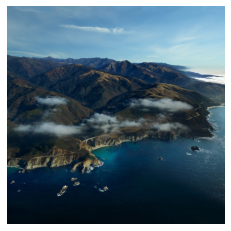

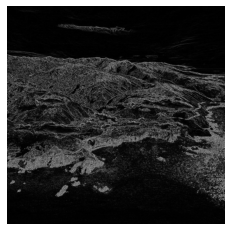

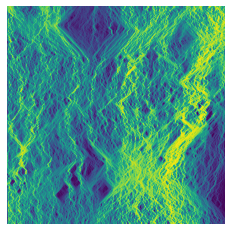

In [24]:
# Find the energy at a given pixel (i, j)
# Pixels on the border are treated differently
def calculate_energy(img, i, j):
    h, w, _ = img.shape
    di = img[max(i - 1, 0), j] - img[min(i + 1, h - 1), j]
    dj = img[i, max(j - 1, 0)] - img[i, min(j + 1, w - 1)]
    return np.sum(di ** 2) + np.sum(dj ** 2)

# Show an image, potentially in black and white
def show_img(img, black_and_white=False):
    if black_and_white:
        plt.imshow((img / img.max() * 255).astype(int), cmap='gray')
    else:
        plt.imshow(img)
    
    plt.axis('off')
    plt.show()

# Solve the dynamic program
# For each pixel, find the minimum NW, N, or NE pixel
def calculate_dp(dp, energy, i, j):
    h, w = energy.shape
    
    min_e = dp[i - 1, j]
    min_p = j

    if j - 1 >= 0:
        if dp[i - 1, j - 1] < min_e:
            min_e = dp[i - 1, j - 1]
            min_p = j - 1

    if j + 1 < w:
        if dp[i - 1, j + 1] < min_e:
            min_e = dp[i - 1, j + 1]
            min_p = j + 1

    return min_e + energy[i, j], min_p

title = 'big-sur'

img = cv2.imread(f'samples/{title}.jpg')[:, :, [2, 1, 0]]
show_img(img)

original_img = img.copy()
h, w, _ = img.shape

# Only calculate energy for the entire image once
energy = np.array([[calculate_energy(img, i, j) for j in range(w)] for i in range(h)])

# Preserve bridge
inf = 1000000000
for i in range(550, 650):
    for j in range(350, 450):
        energy[i, j] = inf

show_img(energy, black_and_white=True)

seams = []

for _ in range(w):
    h, w, _ = img.shape
        
    # 1. Calculate seam
    
    dp = np.zeros(energy.shape)
    for j in range(w):
        dp[0, j] = energy[0, j]

    pointers = np.zeros(energy.shape, dtype=int)
    for i in range(1, h):
        for j in range(w):
            dp[i, j], pointers[i, j] = calculate_dp(dp, energy, i, j)

    seam = []
    
    x = dp[h-1]
    j_arr = np.where(x == x.min())[0]
    j = np.random.choice(j_arr)
    seam.append((h - 1, j, img[h-1, j].copy()))
    
    for i in reversed(range(h - 1)):
        j = pointers[i+1, j]
        seam.append((i, j, img[i, j].copy()))
        
    seams.append(seam)
    
    # 2. Remove seam
    
    for i, j, _ in seam:
        img[i, j:w-1] = img[i, j+1:w]
        energy[i, j:w-1] = energy[i, j+1:w]
    
    # 3. Update energy cells that may have changed (left and right of seam)
    
    for i, j, _ in seam:
        if j - 1 >= 0:
            energy[i, j-1] = calculate_energy(img, i, j - 1)
        energy[i, j] = calculate_energy(img, i, j)
        
    img = img[:, :w-1]
    energy = energy[:, :w-1]

if img.shape[1] > 0:
    show_img(img)

# Reconstruct delete-order data structure
original_h, original_w, _ = original_img.shape

ds = np.zeros((original_h, original_w), dtype=int)
for k, seam in enumerate(reversed(seams)):
    for i, j, _ in seam:
        ds[i, j+1:] = ds[i, j:original_w-1]
        ds[i, j] = k

show_img(ds)

# Double image width with insertions
double_img = cv2.resize(original_img, (0, 0), fx=2, fy=1)
cv2.imwrite(f'samples/{title}-2x.jpg', double_img[:, :, [2, 1, 0]])

h, w = ds.shape
double_ds = np.zeros((h, w * 2), dtype=int)

for k, seam in enumerate(reversed(seams)):
    for i, j, p in seam:
        double_ds[i, 2*(j+1):] = double_ds[i, 2*j:-2]
        double_ds[i, 2*j+0] = k
        double_ds[i, 2*j+1] = 2 * w - 1 - k

with open(f'samples/{title}-data-2x.json', 'w') as file:
    json.dump(double_ds.tolist(), file)